In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plot_folder = "./figs/plots/"

def parse_ltspice_line(line):
    split_line = line.split('\t')
    f = float(split_line[0])
    mag = float(split_line[1].split(',')[0].replace('dB', '').replace('(', ''))
    arg = float(split_line[1].split(',')[1].replace('°)', ''))
    return (f, mag, arg)

def parse_file(filename):
    f = open(filename, "r")
    f.readline()
    freq = []
    mag = []
    arg = []
    for line in f:
        f, m, a = parse_ltspice_line(line)
        freq.append(f)
        mag.append(m)
        arg.append(corregir_fase(a))
    return freq, mag, arg

#Transforma fase de 0 a 360 grados, a -180 a 180 grados
def corregir_fase(fase):
    fase = fase%360
    if fase < 0:
        return 360 - fase
    else:
        return fase

#Levanto datos de la simulacion

ltspice_freq, ltspice_mag, ltspice_arg = parse_file('sim.txt')

#Levanto y proceso datos de las mediciones del osciloscopio

df_osc = pd.read_csv('mediciones.csv', usecols = ['frecuencia_hz','vin_rms', 'vout_rms', 'delay_us'])
osc_freq = df_osc['frecuencia_hz']
osc_mag = [20*np.log10(x[1]/x[0]) for x in zip(df_osc['vin_rms'], df_osc['vout_rms'])] #Calculo la ganancia y convierto a dB
osc_arg = [ corregir_fase(-360*x[0]*x[1]/10**6) for x in zip(df_osc['frecuencia_hz'], df_osc['delay_us'])] #Calculo la fase

#Levanto datos del analizador de audio (modulo)

df_an_mag = pd.read_csv('mediciones_analizador_modulo.csv', usecols = ['freq','mag'])
an_freq_mag = df_an_mag['freq']
an_mag = df_an_mag['mag']

#Levanto datos del analizador de audio (fase)

df_an_arg = pd.read_csv('mediciones_analizador_fase.csv', usecols = ['freq','arg'])
an_freq_arg = df_an_arg['freq']
an_arg = [corregir_fase(x) for x in df_an_arg['arg']]

#Calculo retardo de grupo
#Simulacion
ltspice_delay = -(2*np.pi/360)*np.diff(ltspice_arg)/(2*np.pi*np.diff(ltspice_freq))
ltspice_delay_freq = (np.array(ltspice_freq[1:]) + np.array(ltspice_freq[:-1])) / 2
#Osciloscopio
osc_delay = -(2*np.pi/360)*np.diff(osc_arg)/(2*np.pi*np.diff(osc_freq))
osc_delay_freq = (np.array(osc_freq[1:]) + np.array(osc_freq[:-1])) / 2
#Analizador de audio
an_delay = -(2*np.pi/360)*np.diff(an_arg)/(2*np.pi*np.diff(an_freq_arg))
an_delay_freq = (np.array(an_freq_arg[1:]) + np.array(an_freq_arg[:-1])) / 2

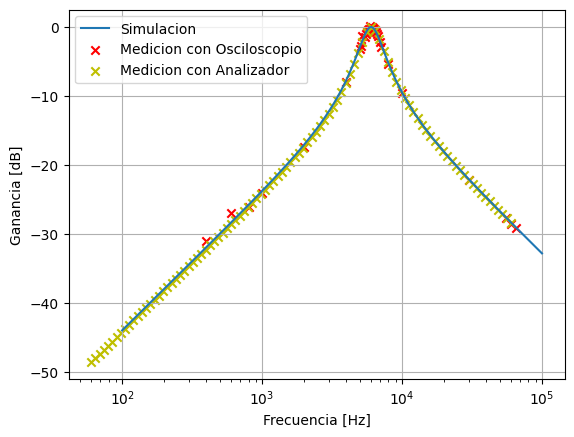

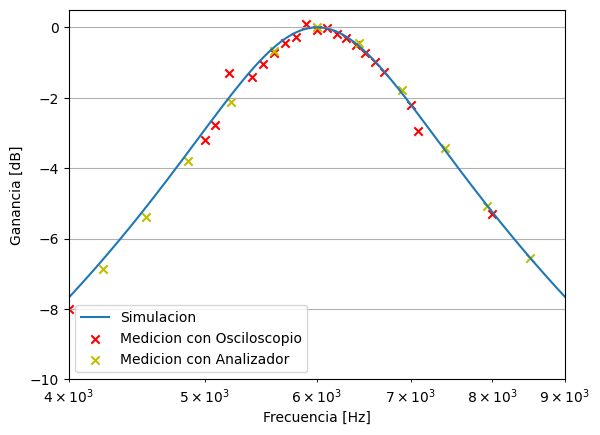

In [56]:
#Grafico modulo

plt.xscale('log')
plt.plot(ltspice_freq, ltspice_mag, label='Simulacion')
plt.scatter(osc_freq, osc_mag, marker='x', color='r', label='Medicion con Osciloscopio')
plt.scatter(an_freq_mag, an_mag, marker='x', color='y', label='Medicion con Analizador')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Ganancia [dB]')
plt.legend()
plt.grid()
plt.savefig(plot_folder + "mag.png", dpi=200)
plt.show()
#Grafico modulo cerca de la banda de paso

plt.xlim(4000, 9000)
plt.ylim(-10, 0.5)
plt.xscale('log')
plt.plot(ltspice_freq, ltspice_mag, label='Simulacion')
plt.scatter(osc_freq, osc_mag, marker='x', color='r', label='Medicion con Osciloscopio')
plt.scatter(an_freq_mag, an_mag, marker='x', color='y', label='Medicion con Analizador')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Ganancia [dB]')
plt.legend()
plt.grid()
plt.savefig(plot_folder + "mag_zoom.png", dpi=200)
plt.show()



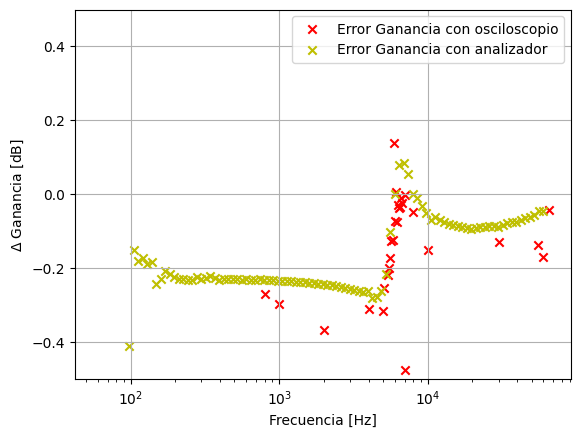

In [57]:
ltspice_mag_for_osc = np.interp(osc_freq, ltspice_freq, ltspice_mag)
ltspice_mag_for_an = np.interp(an_freq_mag, ltspice_freq, ltspice_mag)

err_mag_osc = (osc_mag - ltspice_freq_for_osc)
err_mag_an = (an_mag - ltspice_mag_for_an)

plt.xscale('log')
plt.scatter(osc_freq, err_mag_osc, marker='x', color='r', label='Error Ganancia con osciloscopio')
plt.scatter(an_freq_mag, err_mag_an, marker='x', color='y', label='Error Ganancia con analizador')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('$\Delta$ Ganancia [dB]')
plt.ylim(-0.5,0.5)
plt.legend()
plt.grid()
plt.savefig(plot_folder + "mag_err.png", dpi=200)
plt.show()

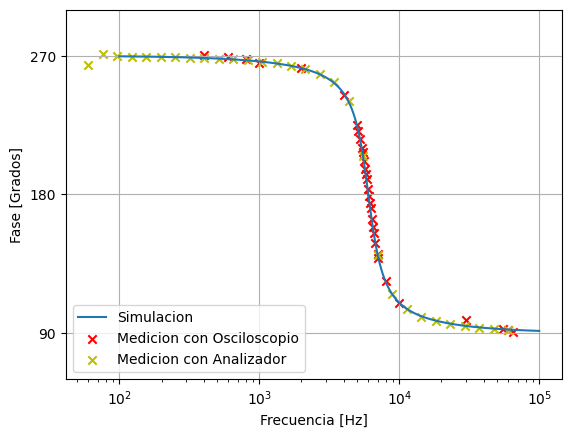

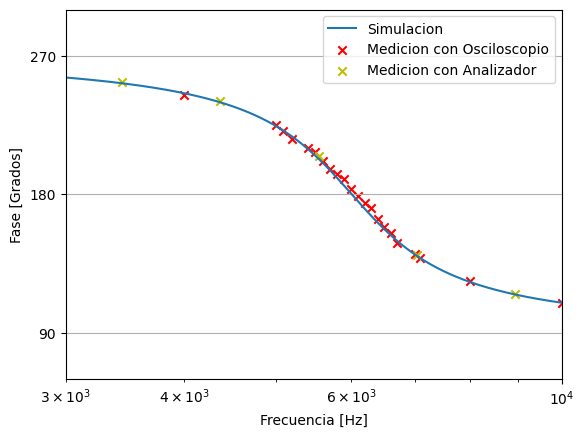

In [59]:
#Grafico fase
plt.ylim(60, 300)
plt.xscale('log')
plt.plot(ltspice_freq, ltspice_arg, label='Simulacion')
plt.scatter(osc_freq, osc_arg, marker='x', color='r', label='Medicion con Osciloscopio')
plt.scatter(an_freq_arg, an_arg, marker='x', color='y', label='Medicion con Analizador')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Fase [Grados]')
plt.yticks([90, 180, 270])
plt.legend()
plt.grid()
plt.savefig(plot_folder + "fase.png", dpi=200)
plt.show()

#Grafico fase cerca de la banda de paso

plt.xlim(3000, 10000)
plt.ylim(60, 300)
plt.xscale('log')
plt.plot(ltspice_freq, ltspice_arg, label='Simulacion')
plt.scatter(osc_freq, osc_arg, marker='x', color='r', label='Medicion con Osciloscopio')
plt.scatter(an_freq_arg, an_arg, marker='x', color='y', label='Medicion con Analizador')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Fase [Grados]')
plt.yticks([90, 180, 270])
plt.legend()
plt.grid()
plt.savefig(plot_folder + "fase_zoom.png", dpi=200)
plt.show()



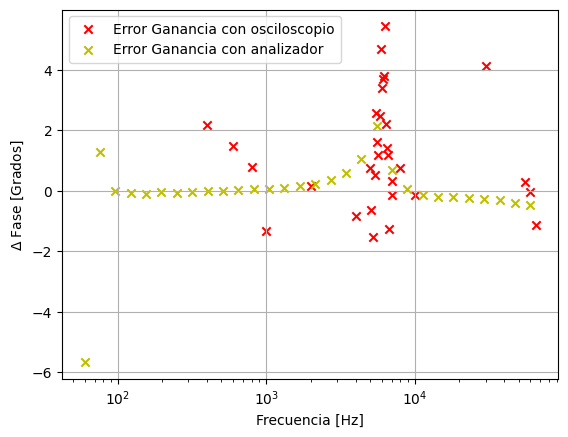

In [61]:
ltspice_arg_for_osc = np.interp(osc_freq, ltspice_freq, ltspice_arg)
ltspice_arg_for_an = np.interp(an_freq_arg, ltspice_freq, ltspice_arg)

err_arg_osc = (osc_arg - ltspice_arg_for_osc)
err_arg_an = (an_arg - ltspice_arg_for_an)

plt.xscale('log')
plt.scatter(osc_freq, err_arg_osc, marker='x', color='r', label='Error Ganancia con osciloscopio')
plt.scatter(an_freq_arg, err_arg_an, marker='x', color='y', label='Error Ganancia con analizador')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('$\Delta$ Fase [Grados]')
plt.legend()
plt.grid()
plt.savefig(plot_folder + "fase_err.png", dpi=200)
plt.show()

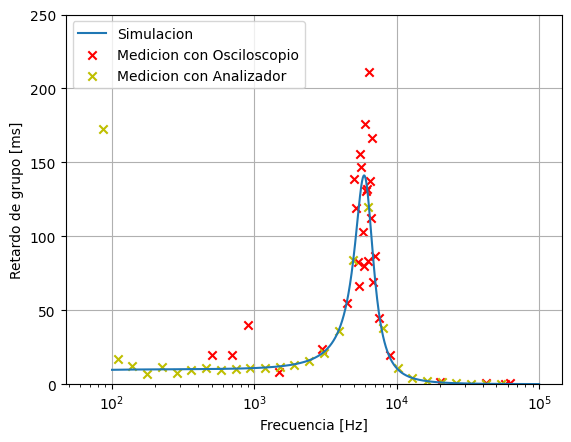

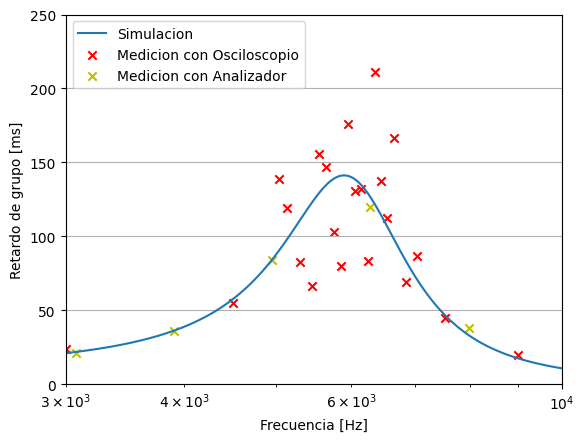

In [49]:

#Grafico retardo de grupo
plt.xscale('log')
plt.plot(ltspice_delay_freq, 10**6*ltspice_delay, label='Simulacion')
plt.scatter(osc_delay_freq, 10**6*osc_delay, marker='x', color='r', label='Medicion con Osciloscopio')
plt.scatter(an_delay_freq, 10**6*an_delay, marker='x', color='y', label='Medicion con Analizador')
plt.ylim([0,250])
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Retardo de grupo [ms]')
plt.legend()
plt.grid()
plt.show()

#Grafico retardo de grupo
plt.xscale('log')
plt.xlim(3000, 10000)
plt.plot(ltspice_delay_freq, 10**6*ltspice_delay, label='Simulacion')
plt.scatter(osc_delay_freq, 10**6*osc_delay, marker='x', color='r', label='Medicion con Osciloscopio')
plt.scatter(an_delay_freq, 10**6*an_delay, marker='x', color='y', label='Medicion con Analizador')
plt.ylim([0,250])
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Retardo de grupo [ms]')
plt.legend()
plt.grid()
plt.show()